Saving Dataset_completo.csv to Dataset_completo (16).csv


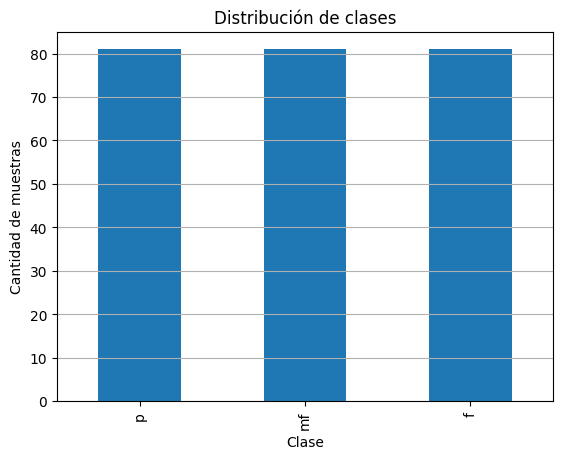

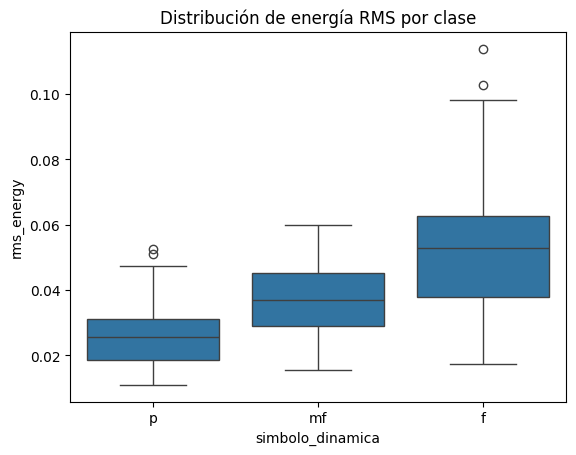


📂 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


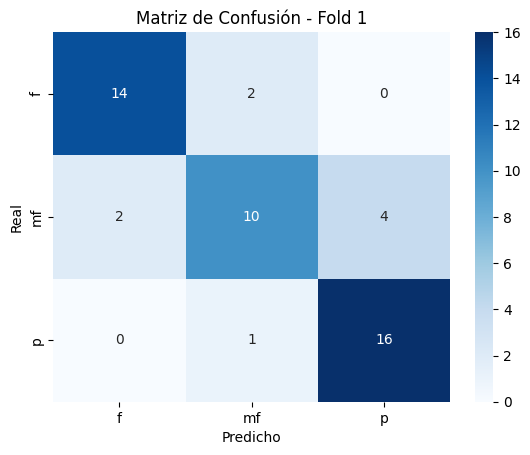


📂 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


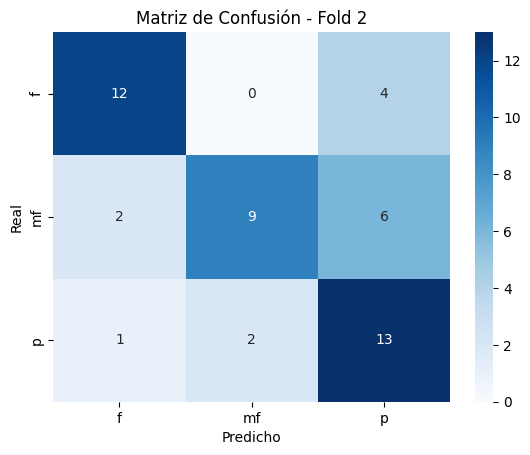


📂 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


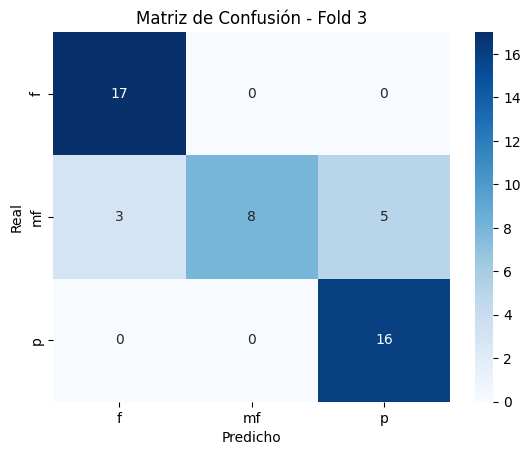


📂 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


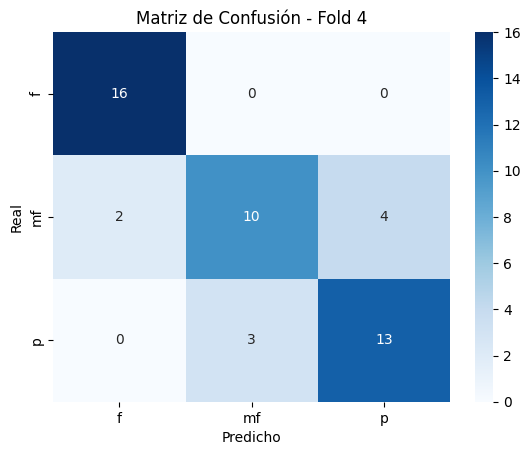


📂 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


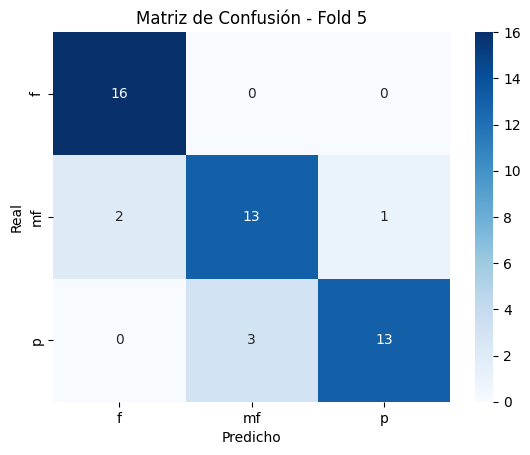


 Promedio de métricas por clase (F1-score, precision, recall):

f    → Precision: 0.86, Recall: 0.93, F1-score: 0.89
mf   → Precision: 0.83, Recall: 0.62, F1-score: 0.70
p    → Precision: 0.76, Recall: 0.88, F1-score: 0.81


In [18]:
# === 0. Subir CSV ===
from google.colab import files
uploaded = files.upload()

# === 1. Librerías ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# === 2. Cargar dataset ===
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# === 3. Visualizar distribución de clases
df["simbolo_dinamica"].value_counts().plot(kind='bar', title="Distribución de clases")
plt.ylabel("Cantidad de muestras")
plt.xlabel("Clase")
plt.grid(axis="y")
plt.show()

# Visualizar un feature relevante: energía RMS
sns.boxplot(data=df, x="simbolo_dinamica", y="rms_energy")
plt.title("Distribución de energía RMS por clase")
plt.show()

# === 4. Preprocesamiento
X = df.drop(columns=[
    "id_archivo", "nota", "octava", "simbolo_dinamica",
    "nombre_dinamica", "version", "clasificacion_duracion",
    "observacion_tecnica"
])
y = df["simbolo_dinamica"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
class_names = le.classes_

# === 5. Calcular class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(weights))

# === 6. Validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
all_reports = []

for train_index, test_index in skf.split(X_scaled, y_encoded):
    print(f"\n📂 Fold {fold}")

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]
    y_test_labels = y_encoded[test_index]

    # === Modelo MLP
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))  # 3 clases

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=8,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=0
    )

    # === Evaluar en test
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # === Reporte
    report = classification_report(y_test_labels, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test_labels, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusión - Fold {fold}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    fold += 1

# === 7. Promediar resultados
def promedio_metrica(reports, clase, metrica):
    return np.mean([fold_report[clase][metrica] for fold_report in reports])

print("\n Promedio de métricas por clase (F1-score, precision, recall):\n")
for clase in class_names:
    f1 = promedio_metrica(all_reports, clase, 'f1-score')
    prec = promedio_metrica(all_reports, clase, 'precision')
    recall = promedio_metrica(all_reports, clase, 'recall')
    print(f"{clase:<4} → Precision: {prec:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
